### ECE-GY 6123
### Nikita Makarov, Fall 2024

### Homework 2

Problem 1a:

In [185]:
from PIL import Image
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

# Create conv2 function
def conv2(A: np.ndarray, B: np.ndarray) -> np.ndarray:
    '''
    Compute and return the same-padded 2D convolution of two matrices A and B.

    Parameters:
    A: 2D numpy array of the first matrix
    B: 2D numpy array of the second matrix

    Returns:
    C: 2D numpy array of the same-padded 2D convolution matrix
    '''

    # Calculate final shape of C and preallocate
    [ma, na] = np.shape(A)
    [mb, nb] = np.shape(B)
    mc = ma + mb - 1
    nc = na + nb - 1
    C = np.zeros([mc,nc])

    # Iterate over all elements in C
    for j in range(-1,mc):
        for k in range(-1,nc):
            for p in range(max(0, j+2-mb), min(ma, j+2), 1):
                for q in range(max(0, k+2-nb), min(na, k+2), 1):
                    C[j+1,k+1] = C[j+1,k+1] + (A[p,q] * B[j-p+1,k-q+1]) # Sum over p and q to compute convolution

    # Subset for 'same' padding
    mi = int(abs(mc-ma)/2) # Starting index for axis 1
    ni = int(abs(nc-na)/2) # Starting index for axis 2
    return C[mi:mi+ma,ni:ni+na]

Problem 1b:

In [186]:
# Create plot_filtering function
def plot_filtering(data: np.ndarray, filter: np.ndarray) -> None:
    '''
    Filter the given image using the given filter and plot the following:
    - Original image and filtered image
    - Log-magnitude spectrum of the original image, filter, and filtered image

    Parameters:
    data: 2D numpy array of the image data in grayscale
    filter: 2D numpy array of the filter matrix
    '''

    # Compute filtered image
    data_filter = conv2(data, filter)
    N = np.shape(data)[0]

    # Create figure for original image
    plt.figure()
    plt.imshow(data, interpolation='none', cmap='gray', vmin=0, vmax=255)
    plt.title('Original Image')
    plt.axis('off')
    plt.colorbar()

    # Create figure for filtered image
    plt.figure()
    plt.imshow(data_filter, interpolation='none', cmap='gray', vmin=0, vmax=255)
    plt.title('Filtered Image')
    plt.axis('off')
    plt.colorbar()

    # Create spectrum of original image
    H = np.abs(np.fft.fft2(data,[N,N]))
    H = np.fft.fftshift(np.log(H+1))
    plt.figure()
    plt.imshow(H, interpolation='none', cmap='gray')
    plt.title('Log-magnitude spectrum of original image')
    plt.axis('off')
    plt.colorbar()

    # Create spectrum of filter
    H = np.abs(np.fft.fft2(filter,[N,N]))
    H = np.fft.fftshift(np.log(H+1))
    plt.figure()
    plt.imshow(H, interpolation='none', cmap='gray')
    plt.title('Log-magnitude spectrum of filter')
    plt.axis('off')
    plt.colorbar()

    # Create spectrum of filtered image
    H = np.abs(np.fft.fft2(data_filter,[N,N]))
    H = np.fft.fftshift(np.log(H+1))
    plt.figure()
    plt.imshow(H, interpolation='none', cmap='gray')
    plt.title('Log-magnitude spectrum of filtered image')
    plt.axis('off')
    plt.colorbar()

Problem 1c:

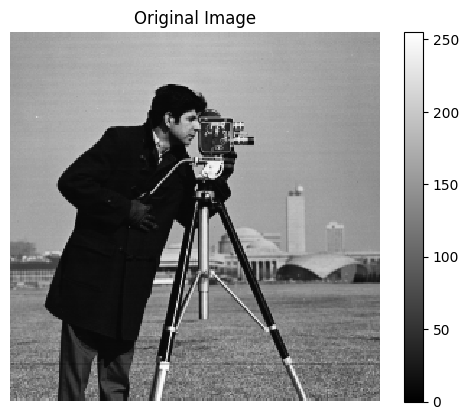

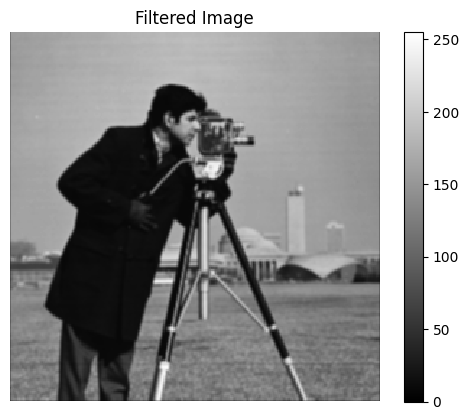

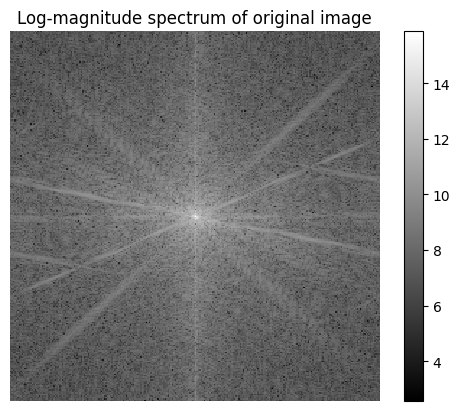

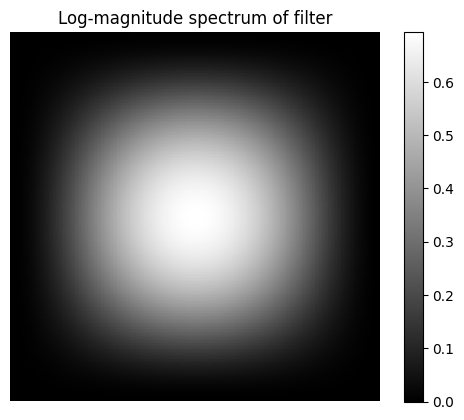

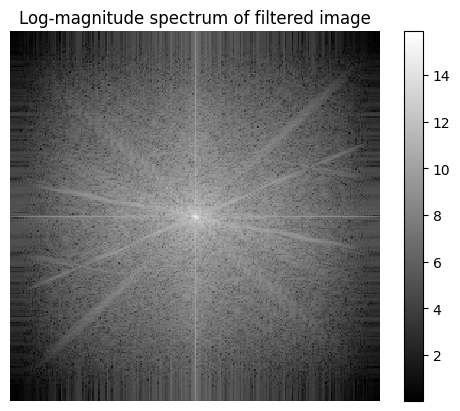

In [187]:
# Load sample grayscale image
img = Image.open('cameraman.tif')
img.load()
image_data = np.asarray(img) # Image is in grayscale with 8 bit depth

# Apply H1 filter to image
H1 = 1/16 * np.asarray([[1,2,1],[2,4,2],[1,2,1]]) # H1 filter matrix
plot_filtering(image_data,H1)

This filter is a low pass filter, since its coefficients are all positive and they sum to 1. These filters are used for noise removal or image smoothing. The frequency response of the filter is in the shape of a Gaussian, meaning it is high for the lower frequencies in the center and low for the higher frequencies at the edges, which agrees with the purpose of the filter. The filtered image does have smoother edges and looks like a noise removal filter has been applied to it. Convolution in the spatial domain is multiplication in the frequency domain, and the frequency response of the filtered image does look like the frequency response of the original image multiplied by the frequency response of the filter.

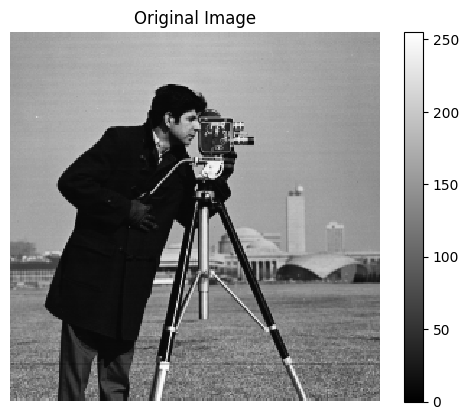

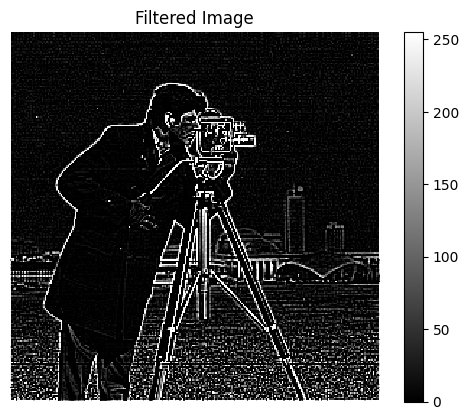

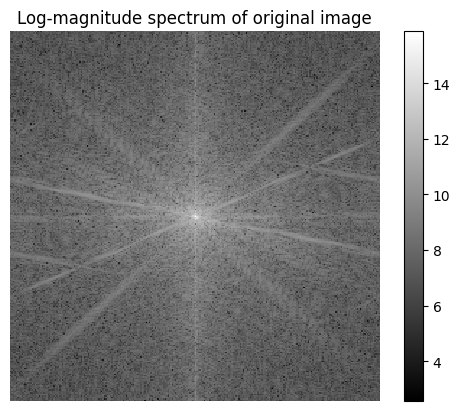

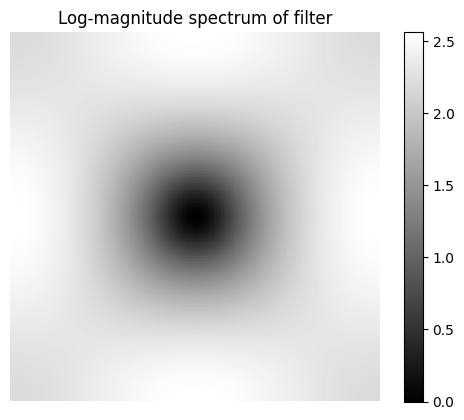

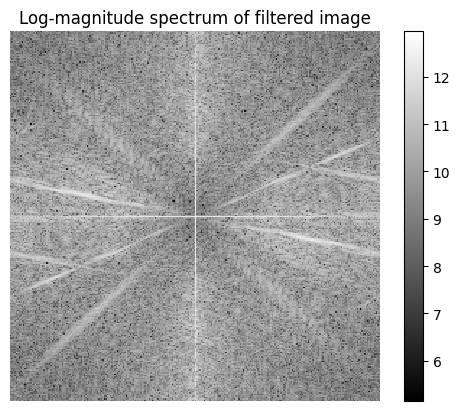

In [188]:
# Apply H2 filter to image
H2 = np.asarray([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]]) # H2 filter matrix
plot_filtering(image_data,H2)

This filter is a high pass filter, since its coefficients sum to 1. These filters are used for edge detection. The shape of the frequency response of the filter is zero in the middle for the lower frequencies, rising up to maximum around the edges for the higher frequencies, which agrees with the purpose of the filter. The filtered image is primarily showing the edges of the original image. Again, the frequency response of the filtered image does look like the frequency response of the original image multiplied by the frequency response of the filter.

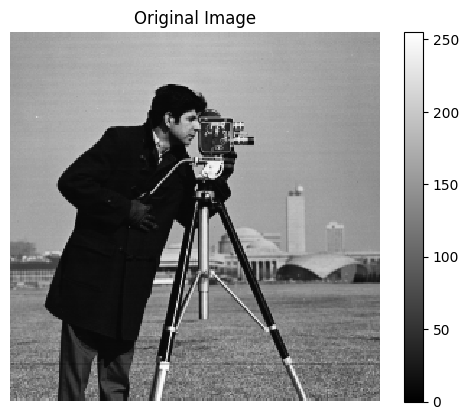

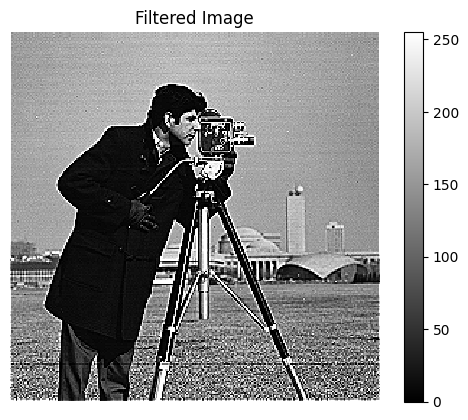

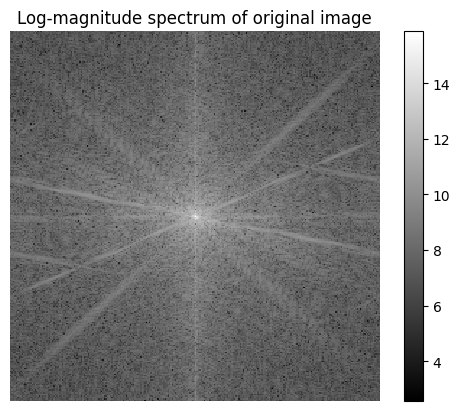

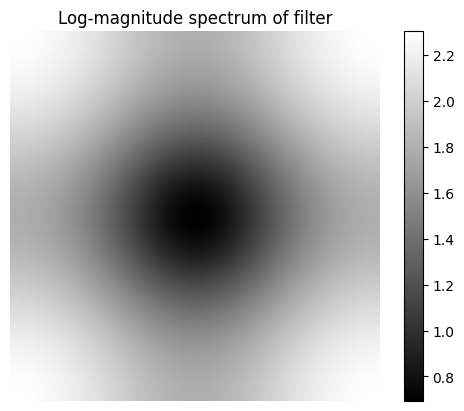

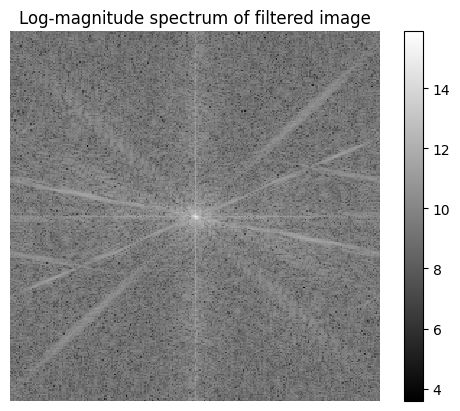

In [189]:
# Apply H3 filter to image
H3 = np.asarray([[0,-1,0],[-1,5,-1],[0,-1,0]]) # H3 filter matrix
plot_filtering(image_data,H3)

This filter is a high emphasis filter, since some of its coefficients are negative and they sum to 1. These filters are used for edge sharpening. The shape of the frequency response of the filter is minimum in the middle for the lower frequencies, rising up to maximum around the corners for the higher frequencies, which agrees with the purpose of the filter. Unlike H2, this filtered image still looks like the original image but with the edges enhanced and sharpened. Again, the frequency response of the filtered image does look like the frequency response of the original image multiplied by the frequency response of the filter.

Problem 2a:

In [221]:
# Create image noise generator function
def awgn(data: np.ndarray, sigma: float) -> np.ndarray:
    '''
    Apply IID zero-mean Gaussian distribution random noise with the given standard deviation to the given image.

    Parameters:
    data: 2D numpy array of the image data, range [0,1]
    sigma: Float of the Gaussian standard distribution

    Returns:
    data: 2D numpy array of the resulting image
    '''

    # Set up random generator and create noise data
    rng = np.random.default_rng()
    noise = rng.normal(0, sigma, np.shape(data))

    # Apply noise to image
    data = data + noise

    # Re-scale image to [0,1]
    data = data + np.abs(np.min(data))
    data = data / np.max(data)

    # Return final noisy image data
    return data

Problem 2b:

In [213]:
# Create gaussian filter generator function
def gaussian_filter(sigma: int) -> np.ndarray:
    '''
    Generate a 2D Gaussian filter of size MxM with the given standard deviation sigma, where M = 5*sigma

    Parameters:
    sigma: Int of the standard deviation

    Returns:
    H: 2D numpy array of the Gaussian filter
    '''

    # Create initial arrays for Gaussian function
    x = np.linspace(-(5*sigma-1)/2,(5*sigma-1)/2,5*sigma) # Array of x, spaced by 1, centered at 0
    x,y = np.meshgrid(x,x) # Create 2D arrays of x and y values
    gauss = np.exp(-(x**2+y**2)/(2*sigma**2)) # Create 2D array of gaussian function

    # Rescale Gaussian to sum to 1
    H = gauss/(np.sum(gauss))

    # Return Gaussian filter
    return H

Problem 2c:

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

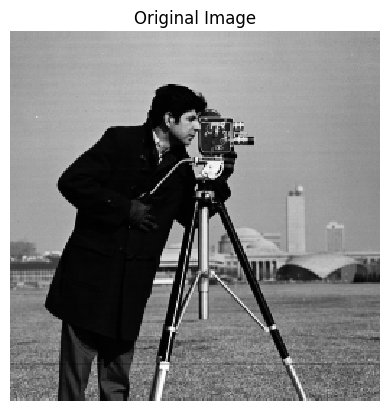

In [216]:
# Load sample grayscale image
img = Image.open('cameraman.tif')
img.load()
img_data = np.asarray(img) # Image is in grayscale with 8 bit depth
img_orig = img_data/255 # Rescale image to [0,1]

# Create figure for original image
plt.figure()
plt.imshow(img_orig, interpolation='none', cmap='gray')
plt.title('Original Image')
plt.axis('off')

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

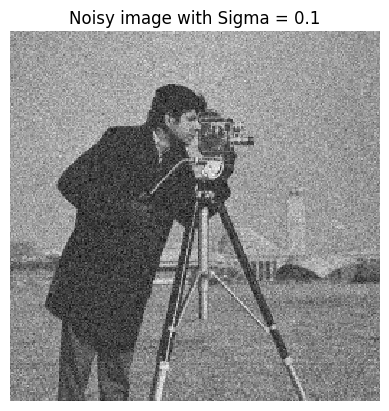

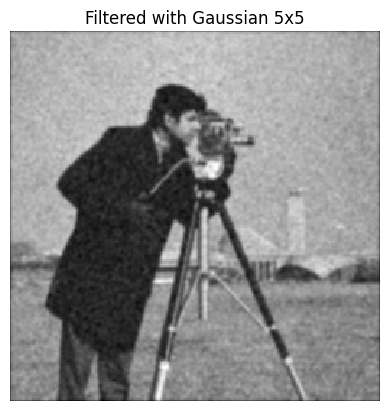

In [220]:
# Add first noise to original image
img_noisy = awgn(img_orig, 0.1)

# Apply Gaussian filter to noisy image
H_gaus = gaussian_filter(1) # Create 5x5 Gaussian filter
img_filtered_gaus = conv2(img_noisy, H_gaus) # Apply filter

# Create figure for noisy image
plt.figure()
plt.imshow(img_noisy, interpolation='none', cmap='gray')
plt.title('Noisy image with Sigma = 0.1')
plt.axis('off')

# Create figure for gaussian filtered image
plt.figure()
plt.imshow(img_filtered_gaus, interpolation='none', cmap='gray')
plt.title('Filtered with Gaussian 5x5')
plt.axis('off')